In [1]:
import yfinance
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperParameters

In [2]:
# load data
ticket = yfinance.Ticker("MSFT")

start_date = datetime.datetime(2021, 1, 11)
end_date = datetime.datetime(2022, 12, 20)

history_prices = ticket.history(start=start_date, end=end_date)

# print(history_prices)
# print(history_prices.shape)

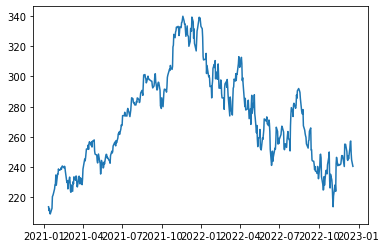

In [3]:
# hourly data
plt.plot(history_prices['Close'])

In [4]:
# Select columns
data_clean = history_prices[["Close"]]
data_clean_ext = data_clean.copy()

n_features = data_clean.shape[1]

# Convert the data to numpy values
np_data_unscaled = np.array(data_clean)

# print(np_data_unscaled)

In [5]:
# Transform the data by scaling each feature to a range between 0 and 1???why this scaler
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
# print(np_data_scaled)

In [6]:
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_close_prices = pd.DataFrame(data_clean_ext[["Close"]])
np_prices_scaled = scaler_pred.fit_transform(df_close_prices)
# print(np_prices_scaled)

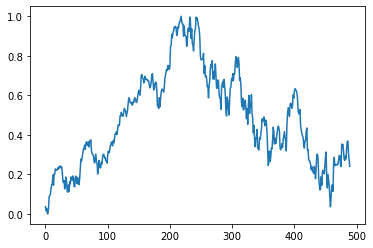

In [7]:
# stationarity
plt.plot(np_prices_scaled)

In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 5  # rolling window size = 5 days

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 75% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.75)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Generate training data and test data
x_train, y_train = split_sequence(train_data, sequence_length)
x_test, y_test = split_sequence(test_data, sequence_length)

In [9]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(363, 5, 1)
(122, 5, 1)
(363, 1)
(122, 1)


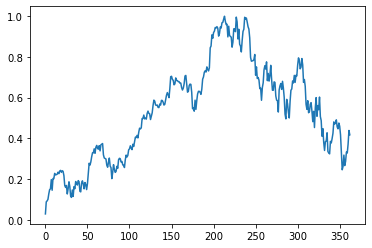

In [10]:
# plot training data
plt.plot(y_train)

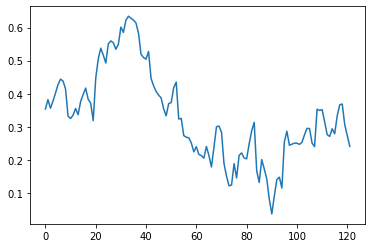

In [11]:
# plot test data
plt.plot(y_test)

In [ ]:
def build_model(hp):
    
    model = Sequential()
    
    # number of dense layer
    dense = hp.Int("n_dense",
                  min_value=0,
                  max_value=10)
    
    # first LSTM-layer
    model.add(LSTM(units=hp.Int("n_units1",
                               min_value=32,
                               max_value=512,
                               step=16),
                  activation=hp.Choice("v_activation_hidden",
                                      values=["relu", "tanh", "sigmoid"],
                                      default="relu"),
                  input_shape=(x_train.shape[1], x_train.shape[2]),
                  return_sequences = False))
            
    # add dense layers
    if dense > 0:
        for layer in range(dense):
            model.add(Dropout(hp.Float("v_dropout_dense" + str(layer + 1),
                                      min_value = 0.05,
                                      max_value = 0.5,
                                      step = 0.01)))
            model.add(Dense(units=hp.Int("n_units_dense" + str(layer + 1),
                                        min_value = 32,
                                        max_value = 512,
                                        step = 16),
                           activation=hp.Choice("v_activation_dense",
                                               values=["relu", "tanh", "sigmoid"],
                                               default="relu")))
            
    model.add(Dropout(hp.Float("v_dropout",
                              min_value=0.05,
                              max_value=0.5,
                              step=0.01)))
    
    model.add(Dense(units=n_features))
    
    model.compile(optimizer = "adam",
                 loss = "mean_absolute_error")
    
    return model

In [ ]:
tuner = RandomSearch(build_model,
                     objective="val_loss",
                     max_trials=50,
                     seed=9999,
                     executions_per_trial=3,
                     directory="",
                     project_name="RandomSearch_Univariate2")

early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

tuner.search(x_train, 
            y_train, 
            epochs=500, 
            batch_size=32, 
            validation_split=0.25,
            callbacks=[early_stopping_cb],
            verbose = 1)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# save best model for that variable combination
best_model.save("best_model_univariate2.h5")

# Evaluate the best model with test data
loss = best_model.evaluate(x_test, y_test)

In [ ]:
model = load_model("best_model_univariate.h5")
#model.summary()
model.get_config()

In [12]:
# Configure the neural network model
model = Sequential()
model.add(LSTM(256, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.06))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.47))
model.add(Dense(n_features))

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 330,241
Trainable params: 330,241
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Check-points and early stopping parameters make our modeling easier
# Specfy the file and file path for the best model
checkpoint_path = 'D:/COLLEGE/COMPS/best_model_univariate.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=0)
callbacks = [checkpoint, earlystopping]

# Training the model
epochs = 500
batch_size = 32
history = model.fit(x_train, y_train,
                     batch_size=batch_size, 
                     epochs=epochs,
                     validation_data=(x_test, y_test),
                     callbacks = callbacks,
                     verbose = 0)

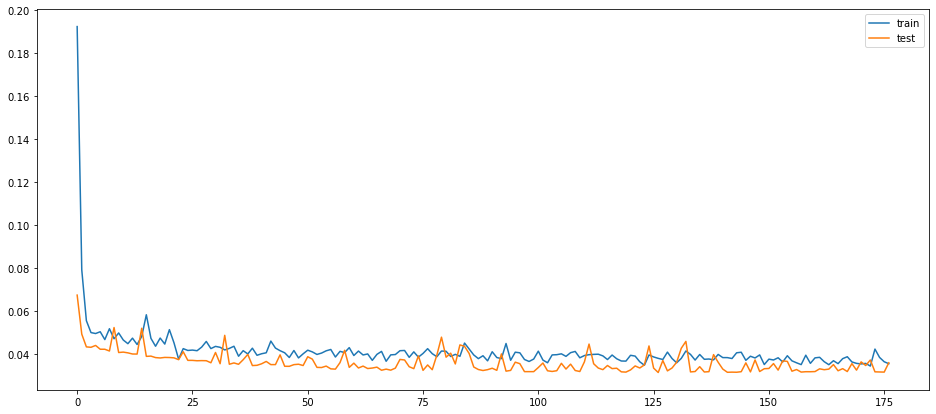

In [14]:
# Load the best model
model_from_saved_checkpoint = load_model(checkpoint_path)

# Plot training & validation loss values
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
# Get the predicted values
y_pred_scaled = model_from_saved_checkpoint.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)

# reshape 
y_test_unscaled = scaler_pred.inverse_transform(y_test)

In [16]:
# Store prediction values in dataframes
y_pred_df = pd.DataFrame(y_pred, columns=["Close"])
y_test_unscaled_df = pd.DataFrame(y_test_unscaled, columns=["Close"])

In [17]:
# MSE
MSE = mean_squared_error(y_test_unscaled, y_pred)
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

# RMSE
RMSE = math.sqrt(mean_squared_error(y_test_unscaled, y_pred))
print(f'Root Mean Squared Error (RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Mean Squared Error (MSE): 30.52
Root Mean Squared Error (RMSE): 5.52
Mean Absolute Error (MAE): 4.1
Mean Absolute Percentage Error (MAPE): 1.65 %
Median Absolute Percentage Error (MDAPE): 1.32 %


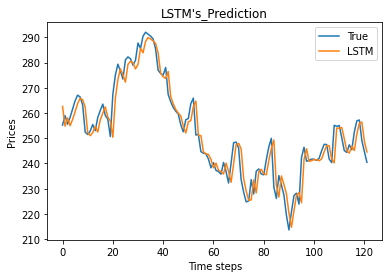

In [18]:
# Plot of the true and predicted prices
plt.plot(y_test_unscaled, label='True')
plt.plot(y_pred, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Time steps')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [19]:
# predictions
n_days_ahead = 30 # 30 days
look_back_df = data_clean.copy()
close_price_pred = []

for i in range(n_days_ahead):
    # New data frame for predicting the next day price
    new_df = look_back_df[-sequence_length:]
    
    # Get the values of the last N day prices 
    # scale the data to be values between 0 and 1
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)
    
    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    
    # Convert the X_test data set to a numpy array and reshape the data
    pred_prices_scaled = model_from_saved_checkpoint.predict(np.array(X_test_new))
    pred_prices_unscaled = scaler_pred.inverse_transform(pred_prices_scaled)
    close_price_pred.append(pred_prices_unscaled[0][0])
    
    # Add predicted data into the dataframe
    look_back_df.loc[len(look_back_df.index)] = pred_prices_unscaled[0]

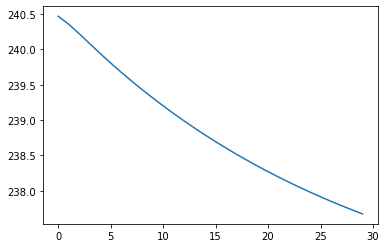

In [20]:
# Plot of predictions
plt.plot(close_price_pred)

In [21]:
# load actual price data
ticket = yfinance.Ticker("MSFT")

start_date_pred = datetime.datetime(2022, 12, 20)
end_date_pred = datetime.datetime(2023, 2, 3)

actual_prices = ticket.history(start=start_date_pred, end=end_date_pred)
actual_prices = actual_prices[["Close"]]

# print(actual_prices)
# print(actual_prices.shape)

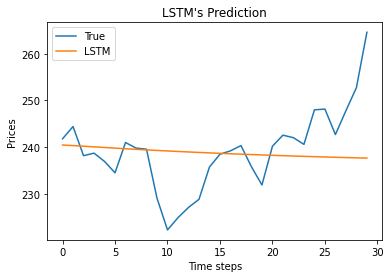

In [22]:
close_price_actual = actual_prices["Close"].values.tolist()

# plot predictions vs. actual
plt.plot(close_price_actual, label='True')
plt.plot(close_price_pred, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Time steps')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [23]:
# clean up results

# Get predicted training data
y_pred_scaled_train = model_from_saved_checkpoint.predict(x_train)

# Unscale the predicted values
y_pred_train = scaler_pred.inverse_transform(y_pred_scaled_train)

# reshape 
y_train_unscaled = scaler_pred.inverse_transform(y_train)

# combine all true stock prices
true_unscaled = np.concatenate((y_train_unscaled, y_test_unscaled)).tolist()
true_unscaled = [item[0] for item in true_unscaled]

# combine all predicted stock prices
predicted_unscaled = np.concatenate((y_pred_train, y_pred)).tolist()
predicted_unscaled = [item[0] for item in predicted_unscaled]

In [24]:
# create date column
history_prices_index = history_prices.index.tolist()
history_prices_dates = [str(date.date()) for date in history_prices_index]
actual_prices_index = actual_prices.index.tolist()
actual_prices_dates = [str(date.date()) for date in actual_prices_index]

In [25]:
# merge results into a dataframe
results = {
    "Date": history_prices_dates[5:] + actual_prices_dates,
    "True": true_unscaled + close_price_actual,
    "LSTM": predicted_unscaled + close_price_pred
}
results_df = pd.DataFrame(data=results)
results_df = results_df.set_index("Date")

In [ ]:
results_df

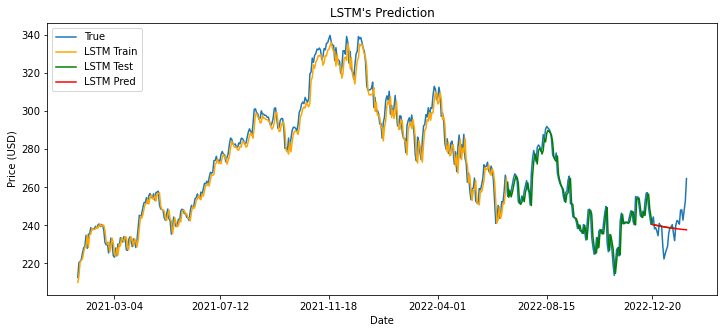

In [26]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Plot of the true and predicted prices
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(results_df['True'], label='True')
ax.plot(results_df['LSTM'][0:train_data_len-sequence_length], label='LSTM Train', color = 'orange')
ax.plot(results_df['LSTM'][train_data_len-sequence_length:-10], label='LSTM Test', color = 'green')
ax.plot(results_df['LSTM'][-30:], label='LSTM Pred', color = 'red')

# Format dates on x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.title("LSTM's Prediction")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()

# plt.savefig('results_univariate.jpg', bbox_inches='tight', dpi=300)
# plt.close()

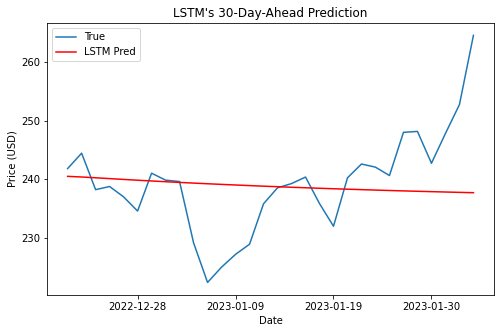

In [27]:
# Zoomed-in plot of predicted prices
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(results_df['True'][-30:], label='True')
ax.plot(results_df['LSTM'][-30:], label='LSTM Pred', color = 'red')

# Format dates on x-axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

plt.title("LSTM's 30-Day-Ahead Prediction")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()

# plt.savefig('results_univariate_30.jpg', bbox_inches='tight', dpi=300)
# plt.close()

In [ ]:
# only compare the most recent 20 days of predictions
close_price_pred = close_price_pred[-20:]
close_price_actual = close_price_actual[-20:]

In [28]:
# prediction metrics 

# MSE
MSE = mean_squared_error(close_price_actual, close_price_pred)
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

# RMSE
RMSE = math.sqrt(mean_squared_error(close_price_actual, close_price_pred))
print(f'Root Mean Squared Error (RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(close_price_actual, close_price_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(close_price_actual, close_price_pred)/ close_price_actual))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(close_price_actual, close_price_pred)/ close_price_actual))) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Mean Squared Error (MSE): 76.03
Root Mean Squared Error (RMSE): 8.72
Mean Absolute Error (MAE): 6.22
Mean Absolute Percentage Error (MAPE): 2.59 %
Median Absolute Percentage Error (MDAPE): 1.64 %


In [ ]:
# run models multiple times to calculate errors
MSEs_30 = []
MAEs_30 = []
MAPEs_30 = []
MSEs_20 = []
MAEs_20 = []
MAPEs_20 = []

for _ in range(10):
    model = Sequential()
    model.add(LSTM(256, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.06))
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.47))
    model.add(Dense(n_features))

    # Compiling the LSTM
    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    checkpoint_path = 'D:/COLLEGE/COMPS/best_model_univariate.hdf5'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                                 monitor='val_loss',
                                 verbose=0, 
                                 save_best_only=True,
                                 mode='min')

    earlystopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=0)
    callbacks = [checkpoint, earlystopping]

    # Training the model
    epochs = 500
    batch_size = 32
    history = model.fit(x_train, y_train,
                         batch_size=batch_size, 
                         epochs=epochs,
                         validation_data=(x_test, y_test),
                         callbacks = callbacks,
                         verbose = 0)
    
    model_from_saved_checkpoint = load_model(checkpoint_path)
    
    # Get the predicted values
    y_pred_scaled = model_from_saved_checkpoint.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)

    # reshape 
    y_test_unscaled = scaler_pred.inverse_transform(y_test)

    # Store prediction values in dataframes
    y_pred_df = pd.DataFrame(y_pred, columns=["Close"])
    y_test_unscaled_df = pd.DataFrame(y_test_unscaled, columns=["Close"])

    # predictions
    n_days_ahead = 30 # 30 days
    look_back_df = data_clean.copy()
    close_price_pred = []

    for i in range(n_days_ahead):
        # New data frame for predicting the next day price
        new_df = look_back_df[-sequence_length:]

        # Get the values of the last N day prices 
        # scale the data to be values between 0 and 1
        last_N_days = new_df[-sequence_length:].values
        last_N_days_scaled = scaler.transform(last_N_days)

        # Create an empty list and Append past N days
        X_test_new = []
        X_test_new.append(last_N_days_scaled)

        # Convert the X_test data set to a numpy array and reshape the data
        pred_prices_scaled = model_from_saved_checkpoint.predict(np.array(X_test_new))
        pred_prices_unscaled = scaler_pred.inverse_transform(pred_prices_scaled)
        close_price_pred.append(pred_prices_unscaled[0][0])

        # Add predicted data into the dataframe
        look_back_df.loc[len(look_back_df.index)] = pred_prices_unscaled[0]

    close_price_actual = actual_prices["Close"].values.tolist()

    MSE = mean_squared_error(close_price_actual, close_price_pred)
    MAE = mean_absolute_error(close_price_actual, close_price_pred)
    MAPE = np.mean((np.abs(np.subtract(close_price_actual, close_price_pred)/ close_price_actual))) * 100

    MSEs_30.append(MSE)
    MAEs_30.append(MAE)
    MAPEs_30.append(MAPE)

    # only compare the most recent 20 days of predictions
    close_price_pred = close_price_pred[-20:]
    close_price_actual = close_price_actual[-20:]

    MSE = mean_squared_error(close_price_actual, close_price_pred)
    MAE = mean_absolute_error(close_price_actual, close_price_pred)
    MAPE = np.mean((np.abs(np.subtract(close_price_actual, close_price_pred)/ close_price_actual))) * 100

    MSEs_20.append(MSE)
    MAEs_20.append(MAE)
    MAPEs_20.append(MAPE)

In [ ]:
print(len(MSEs_30))
print(len(MAEs_30))
print(len(MAPEs_30))
print(len(MSEs_20))
print(len(MAEs_20))
print(len(MAPEs_20))

print(MSEs_30)
print(MAEs_30)
print(MAPEs_30)
print(MSEs_20)
print(MAEs_20)
print(MAPEs_20)

In [ ]:
print(sum(MSEs_30)/len(MSEs_30))
print(sum(MAEs_30)/len(MAEs_30))
print(sum(MAPEs_30)/len(MAPEs_30))
print()
print(sum(MSEs_20)/len(MSEs_20))
print(sum(MAEs_20)/len(MAEs_20))
print(sum(MAPEs_20)/len(MAPEs_20))